# What is the True Normal Human Body Temperature? 

#### Background

The mean normal body temperature was held to be 37°C or 98.6°F for more than 120 years since it was first conceptualized and reported by Carl Wunderlich in a famous 1868 book. But, is this value statistically correct?

<h3>Exercises</h3>

<p>In this exercise, you will analyze a dataset of human body temperatures and employ the concepts of hypothesis testing, confidence intervals, and statistical significance.</p>

<p>Answer the following questions <b>in this notebook below and submit to your Github account</b>.</p> 

<ol>

**<li>  Is the distribution of body temperatures normal? 
    <ul>
    <li> Although this is not a requirement for the Central Limit Theorem to hold (read the introduction on Wikipedia's page about the CLT carefully: https://en.wikipedia.org/wiki/Central_limit_theorem), it gives us some peace of mind that the population may also be normally distributed if we assume that this sample is representative of the population.
    <li> Think about the way you're going to check for the normality of the distribution. Graphical methods are usually used first, but there are also other ways: https://en.wikipedia.org/wiki/Normality_test
    </ul>**

We will start by importing necessary packages. Then we will read in the data and make sure they were imported correctly.

In [1]:
# Import packages
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns

import statsmodels
import statsmodels.api as sm
import scipy
import scipy.stats as stats


# Import data (only relevant columns)
df = pd.read_csv('data/human_body_temperature.csv', usecols=['temperature', 'gender'])

# Inspect the data
df.head()

,temperature,gender
0,99.3,F
1,98.4,F
2,97.8,M
3,99.2,F
4,98.0,F


In [2]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 130 entries, 0 to 129
Data columns (total 2 columns):
temperature    130 non-null float64
gender         130 non-null object
dtypes: float64(1), object(1)
memory usage: 2.1+ KB


The data seem to have been imported correctly.  The variables have the right types, and there are no missing values. 

So let's answer the question about normality. We will start with a Q-Q Plot, which plots the quantiles of the observed distribution against the quantiles we would expect if the distribution was normal:

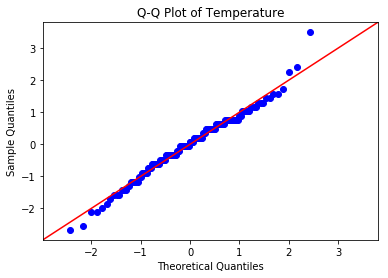

In [3]:
fig = sm.qqplot(df.temperature, stats.norm, fit=True, line='45')
plt.title('Q-Q Plot of Temperature')
plt.show()

The plot shows that the data points do not perfectly lie on the 45° line, as we would expect if the distribution was normal. The observed distribution of temperature has slightly wider tails (more extreme values) than a normal distribution. 

However, we cannot expect the observed and the theoretical quantile's to overlap perfectly in finite samples. Thus, we have to do a significance test to determine if this deviation could easily have been produced by random noise alone, or if it is substantial enough that we should reject the hypothesis that body temperature is normally distributed. One of the best tests for normality is the Shapiro-Wilk Test, so let's apply it:

In [4]:
# Conduct Shapiro-Wilk test, return only p-value
round(stats.shapiro(df.temperature)[1], 2)

0.23

The test yields a p-value of 0.23. Therefore, we cannot reject the null hypothesis that body temperature is normally distributed. 

**<li>  Is the sample size large? Are the observations independent?
    <ul>
    <li> Remember that this is a condition for the Central Limit Theorem, and hence the statistical tests we are using, to apply.
    </ul>**

First let's look at the sample size:

In [5]:
df.shape[0]

130

We have 130 observations. There is no exact minimum number of observations for  asymptotic properties to hold, since convergence to the normal distribution depends on many factors.  For a simple t-test, 130 observation would almost certainly be enough (amongst other, because the t-test is pretty robust against all but the most extreme violations of its assumptions). 

However, our test does *not* rely on the CLT anyway: Since our sample seems to be normally distributed, our test statistic will also be normally distributed, and we therefore don't need the CLT and asymptotics. As a result, we don't have to worry about whether the size of the sample (except in so far as this increases the margin of error, but that is something we can observe directly).

Now let's check for independence. Since we are dealing with cross-sectional observations, not a time-series, it is hard to imagine that the observations would be dependent. The only circumstance under which independence might conceivably be violated is a very specific form of measurement error that has memory (e.g., if the error at a point in time is the sum of measurement errors in the past).  Furthermore, note that even weak dependence would still be compatible with the Central Limit Theorem. Only if the dependence between observations is so strong as to make the process non-stationary would our results be invalidated.

Even though such a strong dependence is extremely unlikely, let's test for independence just in case.  We will start by plotting the autocorrelation and partial autocorrelation for the first 20 lags. 

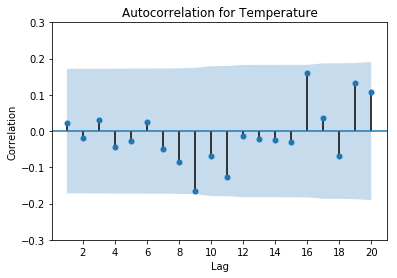

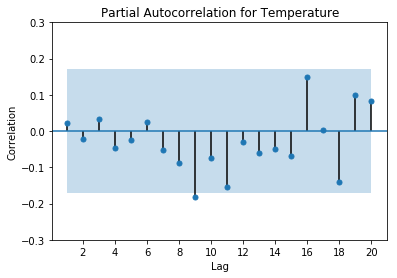

In [6]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
# Plot autocorrelation
plot_acf(df.temperature, lags=20)
plt.xlim([0.1, 21]) # Remove lag 0
plt.ylim([-.3, .3])
plt.ylabel('Correlation')
plt.xlabel('Lag')
plt.title('Autocorrelation for Temperature')
plt.xticks(range(2, 21, 2))
plt.show()

# Plot partial autocorrelation
plot_pacf(df. temperature, lags=20)
plt.xlim([0.1, 21]) # Remove lag 0
plt.ylim([-.3, .3])
plt.ylabel('Correlation')
plt.xlabel('Lag')
plt.title('Partial Autocorrelation for Temperature')
plt.xticks(range(2, 21, 2))
plt.show()
plt.close()

These plots do not show any evidence of dependence. The autocorrelations for all 20 lags is within the 95% confidence interval (though one is at the border), and only one of the partial autocorrelations lies outside this confidence interval.  Since we are conducting 2\*20=40 tests, we expect 0.05\*40=2 of these tests to lead to significant results (to lie outside the confidence interval), even if the null hypothesis of no autocorrelation is true. Thus, since we actually observe less than that (only one, with a further one at the border), there is no evidence of autocorrelation.

Now, to be on the safe side, let's conduct the bootstrap test for independence. To do so, we need to calculate the distribution of temperature's autocorrelation under the null hypothesis of independence. The most literal way of doing this would be by simply permuting the observations, and then repeat this a large number of times. 

However, I will use a more computationally efficient shortcut: Instead of permuting the observations (drawing *without* replacement), I will draw from them *with* replacement. This amounts to using a bootstrap. The primary advantage of this is that it allows us to create all samples in a single draw, whereas permutation would require a for-loop. (This is because if we draw without replacement, the length of the output array cannot be greater than the length of the input array, and NumPy doesn't have any other implementation for conducting multiple permutations at once.)

There should not be any downsides to this shortcut, since the distribution of both autocorrelation statistics should be identical. The reason is that random sampling – whether with or without replacement – breaks any dependence between adjacent temperature samples. Furthermore, sampling with replacement (the bootstrap approach) gives us temperature samples that closely approximate the data-generating process - the "real" distribution (e.g., in terms of mean, variance, and higher-order moments). Since the bootstrap samples of temperature should thus have the same distribution as the permutations of temperature, the distribution of the autocorrelation statistics computed over both distributions should also be the same.

Once we have the distribution of the temperature samples under the null hypothesis, we can then determine where in this distribution the observed autocorrelation falls. We simply count the proportion of observation from this distribution that are more extreme than the observed value, which gives us the one-sided p-value. Since we are conducting a two-sided test (because the autocorrelation could both be positive and negative), we multiply this number by two, which gives us the two-sided p-value.

In [7]:
def p_value(replicates, observed_stat, two_sided=True):
    """
    Computes the p-value of a test statistic using bootstrap replicates.
    
    Parameters
    ----------
    replicates : pd.Series
        bootstrap replicates (i.e., the value of the test statistic for
        each bootstrap sample.
    observed_stat : numeric
        Value of the test statistic in the actual sample.
    two_sided : bool, optional
        Whether to conduct a one-sided or two-sided hypothesis test.
        Default: True (two-sided).
        
    Returns
    -------
    numeric
        p-value
    """
    
    # First compute what percentage of bootstrap replicates are LOWER
    p = (replicates < observed_stat).mean() 
    # If more than half are LOWER, compute what percentage is HIGHER 
    # (since we are interested in what proportion is more extreme).
    if p > 0.5:
        p = (replicates > observed_stat).mean()
    
    # If conducting a 2-sided test, adjust the p-value accordingly
    if two_sided == True:
        p = 2 * p
    return(p)


def bootstrap_p_value(data, statistic, stat_observed, n_samples=10000, seed=1):
    """
    Calculates the p-value for given data and test statistic using the bootstrap.
    
    This function can be used in two different ways:
    1. It can be used directly if we are interested in testing for independence.
    2. It can be called on data that have been shifted or rescaled in order to
       simulate the distribution under the null hypothesis.This allows us to 
       test whether a sample has a given mean or variance. For example, the 
       function b_test_1samp() uses this function to conduct a one-sample test 
       for the mean.
       
    Parameters
    ----------
    data : Series or DataFrame
        The data from which to sample the null hypothesis.
    statistic : function
        Test statistic to be calculated.
    stat_observed : numeric, optional
        Observed test statistic. 
    n_samples : int, optional 
        The number of bootstrap samples to draw. Default: 10000.
    seed : int, optional
        Random seed for resampling. 
        
    Returns
    -------
    numeric
        p-value of test statistic
    """
   
    # Make random number generator
    rng = np.random.RandomState(seed)
    # Draw bootstrap samples (each column contains one sample)
    bootstrap_samples = rng.choice(data, size=(len(data), n_samples))
    
    # For each sample, compute test statistic
    stat_replicates = np.apply_along_axis(func1d=statistic, axis=0, 
                                          arr=bootstrap_samples)
    
    # Compute p-value
    return(p_value(stat_replicates, stat_observed))
 

# Define a function that computes autocorrelation   
def ac(data):
    """Computes the autocorrelation of a Series using NumPy"""
    return (np.corrcoef(data[:-1], data[1:])[0,1])


# Conduct bootstrap test for independence
bootstrap_p_value(df.temperature, statistic=ac, stat_observed=ac(df.temperature))

0.7438

The bootstrap test supports our suspicion that the data are independent. It returns a p-value of 74%, which means that if the null hypothesis of no autocorrelation were true, there is a 74% chance of observing a correlation that is at least as far from 0 as we observed in the sample. Since this is far from being smaller than 5%, we except the alternative hypothesis that the data are indeed independent.

**<li>  Is the true population mean really 98.6 degrees F?
    <ul>
    <li> First, try a bootstrap hypothesis test.
    </ul>**

Before we conduct a test, let's see what the actual mean is in our sample:

In [8]:
round(df.temperature.mean(), 2)

98.25

In our sample, the mean body temperature is 98.25°F. Now let's test whether this is significantly different from 98.6°F.

In [9]:
def btest_1samp(data, test_value, n_samples=10000, two_sided=True):
    """
    Tests whether the mean of a pd.Series is equal to a given value.
    
    Parameters
    ----------
    data : Series or DataFrame
        The data from which to sample the null hypothesis.
    test_value : numeric
        The mean under the null hypothesis.
    n_samples : int, optional 
        The number of bootstrap samples to draw. Default: 10000.
    two_sided : bool, optional
        Whether to conduct a one-sided or two-sided hypothesis test.
        Default: True (two-sided).
    
    Returns
    -------
    numeric
        p-value of test statistic
    """

    # Compute observed mean
    mean_observed = data.mean()
    
    # Compute mean of the data and make it equal to null hypothesis
    data_shifted = data - mean_observed + test_value
    
    # Call bootstrap function to calculate p-value
    p_value = bootstrap_p_value(data_shifted, 
                                stat_observed=mean_observed, 
                                statistic=np.mean)
    
    return(p_value)


# Conduct bootstrap hypothesis test whether population mean is really 98.6° F
btest_1samp(data=df.temperature, test_value=98.6)

0.0

The bootstrap test returns a p-value of zero. This means that it is extremely unlikely that we would observe the data we did if the mean temperature was really 98.6°, as the null hypothesis assumed. Thus, we instead accept the alternative hypothesis that the average body temperature is different from 98.6°. Since our observed average was smaller than 98.6°F, we know that any hypothesis test that took any value greater than that as its null hypothesis would also be rejected. As a result, we can conclude that the true value is below 98.6°F.

**<li> Now, lets try frequentist statistical testing. Would you use a one-sample or two-sample test? Why?**

We will need a one-sample test, because we are comparing the mean from a single sample to a given mean, 98.6, rather than comparing the means of two different examples. 

**<li> In this situation, is it appropriate to use the $t$ or $z$ statistic?**

Our test will use the t-statistic rather than the z-score, because there is uncertainty not only about the mean (which follows a normal distribution), but also the variance (which is proportional to a chi-square distribution).  Since our test statistic – the normalized deviation of the sample mean from 98.6 – is a (modified) ratio of those 2 distributions, we get a t-distribution. This converges to a normal distribution as the sample size goes to infinity. While 130 samples is far from infinity, the two tests will probably yield similar results, because 130 samples is enough to estimate the sample variance with reasonable accuracy. However, since there is no additional cost of conducting a t-test, we might as well do so. 

(Before the widespread use of computers, the z-test had the advantage of only requiring a single table of the normal distribution, whereas the t-test required a separate table of the t-distribution for each number of the test's degrees of freedom.  However, this reason to prefer the z-test is now obsolete.)

Now let's carry out the t-test:

In [10]:
stats.ttest_1samp(df.temperature, 98.6)

Ttest_1sampResult(statistic=-5.4548232923645195, pvalue=2.4106320415561276e-07)

Like the bootstrap test above, the t-test clearly rejects the null hypothesis that the average body temperature is 98.6. We can be quite confident in this result, as the p-value is again very close to 0.

**    <li> Now try using the other test. How is the result different? Why?**

Let's try the z-test:

In [11]:
statsmodels.stats.weightstats.ztest(
    x1=df.temperature.values, 
    value=98.6)

(-5.4548232923645195, 4.9021570141012155e-08)

The first value of the printout is the test statistic, the second value is the p-value. As expected, the result is similar to the t-test: The sample mean is far enough from 98.6 that we can confidently reject the null hypothesis. If we take a look at the p-value, we see that it is even lower, which means that the z-test is slightly overconfident.  This stems from the fact that the t-distribution has wider tails than the standard normal distribution, because the t-distribution factors in the additional uncertainty introduced by having to estimate the sample variance. However, as expected, 130 observations are enough to estimate the sample variance reasonably well. As a result, the difference between both tests is small.

**<li>  Draw a small sample of size 10 from the data and repeat both frequentist tests. 
    <ul>
    <li> Which one is the correct one to use? 
    <li> What do you notice? What does this tell you about the difference in application of the $t$ and $z$ statistic?
    </ul>**

In [12]:
# Randomly sample 10 observations
rng = np.random.RandomState(1)
sample = rng.choice(df.temperature, size=10, replace=False)

# Conduct t-test
t_test_small = stats.ttest_1samp(sample, 98.6)

print('t-test results:\n {} \n' \
      .format(np.round_(t_test_small, 3)))

# Conduct z-test
z_test_small = statsmodels.stats.weightstats.ztest(sample, value=98.6)

print('z-test results:\n {}' \
    .format(np.round_(z_test_small, 3)))

t-test results:
 [-1.966  0.081] 

z-test results:
 [-1.966  0.049]


Since we are only dealing with a sample of 10 observations here, the difference between both tests is more pronounced: The t-test gives us a p-value of 8%, which does not allow us to reject the null hypothesis at the conventional significance level of 5%.  By contrast, the z-test returns a p-value of 4.9%, which is marginally significant at the 5% level, and thus does allow us to reject the null hypothesis.

The fact that we see a bigger difference between both tests here is that the small sample size – only 10 observations, compared to 130 for the full sample – is not enough to accurately estimate the variance of temperature. As a result, the t-test properly adjusts for this additional uncertainty by taking into account that the distribution of the test statistic thus has wider tales.  By contrast, the z-test does not do so – it treats our estimate of variance as if it were a known constant – and thus leads to overconfidence: As a result, it prematurely concludes that the difference between the sample mean and observed mean is significant, while in fact we don't have enough evidence to know whether this difference is instead caused by random noise.

**<li>  At what temperature should we consider someone's temperature to be "abnormal"?
    <ul>
    <li> As in the previous example, try calculating everything using the boostrap approach, as well as the frequentist approach.
    <li> Start by computing the margin of error and confidence interval. When calculating the confidence interval, keep in mind that you should use the appropriate formula for one draw, and not N draws.
    </ul>**

Let's use the bootstrap approach to randomly draw observations of temperature.  We can then use the 2.5th and 97.5th percentile of this distribution to construct a 95% confidence interval. (Of course, we could also argue for taking the 80% or 99% confidence interval as the best operationalization of the "normal" temperature range.  However, it's good to follow convention, as this reduces our leeway to simply pick the confidence level that confirms our favorite hypothesis.)

In [13]:
def bootstrap_ci_indiv(data, n_samples=10000, q=[2.5, 97.5]):
    """Calculate a confidence interval for an individual observation."""

    # Sample n_samples points
    samples = np.random.choice(data, size=n_samples)
    # Compute bootstrap confidence interval
    return(np.percentile(samples, q))
       

# Compute confidence intervals for an individual observation
ci_i = bootstrap_ci_indiv(data=df.temperature)
ci_i

array([96.7, 99.5])

In [14]:
# Margin of error
m_b = (ci_i[1] - ci_i[0]) / 2
round(m_b, 2)

1.4

The bootstrap test yields a 95% confidence interval from 96.7° to 99.5°F, which means we can be 95% confident that the true value lies within this interval. (To be precise, in repeated samples drawn from the same data generating process, a confidence interval calculated this way will contain the true mean in 95% of cases.) The size of our confidence interval implies a margin of error of 1.4°F. 

The instructions don't explicitly say whether the sample disregarded sick individuals.  However, even if it did not, the 95% confidence interval should largely exclude people with a fever, because at each point in time only a small percentage of people should suffer from it. 

These findings imply that the normal body temperature exhibits a sizable amount of individual variation. This means that it is hard to diagnose a fever unless we have that specific person's normal temperature from previous measurements, or unless the fever is sufficiently high.

Let's confirm these results by calculating a classical parametric confidence interval:

In [15]:
# Parametric confidence interval
# Mean
mean_temperature = df.temperature.mean()
# Standard deviation
sd_temperature = df.temperature.std()
# 2.5th and 97.5th percentile of t-distribution
ci = pd.Series(scipy.stats.t.interval(0.95, df=len(df)))

# Confidence interval
temperature_ci_classical = (mean_temperature + ci*sd_temperature)
print(round(temperature_ci_classical, 2))

0    96.8
1    99.7
dtype: float64


In [16]:
# Margin of error
m_p = (temperature_ci_classical[1] - temperature_ci_classical[0]) / 2
m_p

1.4505151934534553

The parametric confidence interval is similarly wide, from 96.8°F to 99.7°F. The margin of error likewise is very close to the results from the bootstrap, at 1.4°F.  Thus, it appears that there is indeed a considerable amount of individual variation.

**<li> Is there a significant difference between males and females in normal temperature?
    <ul>
    <li> What testing approach did you use and why?
    </ul>**

To investigate whether there is a gender difference in normal body temperature, I will conduct an independent samples hypothesis test for the mean.  I will carry this out first using the bootstrap, and then using a classical t-test. The null hypothesis is that there is no difference on average. An appropriate test statistic is the difference between average male and average female body temperature. 

To simulate the distribution of this test statistic under the null hypothesis, we break the link between body temperature and gender by randomly assigning a gender to each temperature measurement. We then determine where in this distribution the actually observed difference lies. If it does not lie between the 2.5th and 97.5th percentiles, it is unlikely that the observed difference in body temperatures is generated from a distribution with no gender difference, and we would therefore reject this null hypothesis. 

In [17]:
def permutation_stat(dataframe, v, group, statistic, rng):
    """
    Create a single permutation of the data, randomly assign groups, 
    and compute test statistic.
    
    Parameters
    ----------
    df : pd.DataFrame
        The data frame where the relevant variables are located.
    v : str
        Name of the variable in the data frame that contains the
        data for which to compute means.
    group : str
        Name of the variable in the data frame that contains a
        categorical variable that identifies the two groups for
        which to compute the test statistic.
    statistic : function
        Function that returns the test statistic of interest.
    rng : np.RandomState instance
        Random number generator.

    Returns
    -------
    numeric
        Value of the test statistic for the permutation sample.
    """

    # Permute values
    v_permuted = rng.permutation(dataframe.loc[:, v])
    
    # Randomly assign groups
    group_1 = v_permuted[: group_value_counts[0]]
    group_2 = v_permuted[group_value_counts[1]:]
    
    # Return test statistic
    stat = statistic(group_1, group_2)
    return(stat)

In [18]:
def btest_2samp(df, v, group, statistic, n_permutations=10000):
    """
    Performs a 2-sample hypothesis test using the bootstrap
    
    Parameters
    ----------
    df : pd.DataFrame
        The data frame where the relevant variables are located.
    v : str
        Name of the variable in the data frame that contains the
        data for which to compute means.
    group : str
        Name of the variable in the data frame that contains a
        categorical variable that identifies the two groups for
        which to compute the test statistic.
    n_permutations : numeric, optional
        Number of bootstrap replicates.  Default: 10000

    Returns
    -------
    numeric
        p-value 
    """

    # Count number of observations in each group
    global group_value_counts # For some reason, doesn't work otherwise
    group_value_counts = df.loc[:, group].value_counts()
    
    # Compute actual test statistic
    data_1 = df.loc[df[group]==group_value_counts.index[0], v]
    data_2 = df.loc[df[group]==group_value_counts.index[1], v]
    actual_stat = statistic(data_1, data_2)
    
    # Create random number generator
    rng = np.random.RandomState(3)
    
    # Compute test statistic for each permutation replicate
    permutation_stats = np.empty(shape=n_permutations)
    for replicate in range(n_permutations):
        permutation_stats[replicate] = permutation_stat(df, v, group, 
                                                        statistic, rng)

    # Compute p-value
    return(p_value(permutation_stats, actual_stat))


# Define function to compute difference in means
def diff_in_means(s1, s2):
    """ Returns the difference in means between two pd.Series."""
    return (s1.mean() - s2.mean())


# Conduct 2-sample hypothesis test
print('p-value: ', btest_2samp(df, 'temperature', group='gender', 
                    statistic=diff_in_means), '\n')

# Take a look at actual means to determine which group has the higher mean
print(df.groupby('gender').mean())

p-value:  0.0192 

        temperature
gender             
F         98.393846
M         98.104615


The test returns a two-sided p-value of 2.7%.  In other words, if the null hypothesis – that there is no gender difference in average body temperature – was true, then there is only a small chance that we would observe a difference in temperature as big as in our sample. Thus, we can reject the null hypothesis of no difference at the conventional significance level of 5%. Instead, we can be pretty sure that women's body temperature is higher than men's. Note, however, that the effect size is small: The observed difference is only about 0.2°F.

To check the result, let's also conduct a classical t-test for independent samples:

In [19]:
# Conduct a parametric hypothesis test
np.round_(  
    stats.ttest_ind(df.loc[df.gender=='M', 'temperature'], 
                    df.loc[df.gender=='F', 'temperature']), 
    2)

array([-2.29,  0.02])

The classical t-test yields a similar conclusion: It returns a p-value of 2.4%, and thus would lead us to draw the same conclusion.

**<li> Write a story with your conclusion in the context of the original problem.**

It has long been assumed that the normal human temperature is 98.6°F (37.0°C). However, our analysis above suggests that it is in fact lower than that.  Our sample of 130 people puts the best estimate (i.e., the maximum likelihood estimate) at 98.25°.

At the same time, it is also important to take into account that there is quite a bit of individual variation: For any given person, the 95% confidence interval spans from 96.7° to 99.5°. Furthermore, there is also a small but significant gender difference: women's body temperature is, on average, 0.2°F higher than men's.

Overall, it does appear that the long-standing estimate of 98.6°F might just have been chosen because it corresponds to a rounded number in degrees Celsius. For many applications, this may be close enough – especially since there is also a sizable individual variation. However, if increased accuracy is needed, we should remember that the most precise estimate of the average body temperature is lower.